In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv', nrows=50000)

In [2]:
data.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2


In [3]:
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

In [4]:
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

X = data[base_features]

In [5]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(train_X, train_y)

In [6]:
train_X.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,-73.976827,40.756931,-73.975359,40.757434,1.662320
std,0.014625,0.018206,0.015930,0.018659,1.290729
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.987964,40.744901,-73.987143,40.745756,1.000000
50%,-73.979629,40.758076,-73.978588,40.758542,1.000000
75%,-73.967797,40.769602,-73.966459,40.770406,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [7]:
train_y.describe()

count    23466.000000
mean         8.472539
std          4.609747
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

It would be helpful to know whether New York City taxis vary prices based on how many passengers they have. Most places do not change fares based on numbers of passengers. If you assume New York City is the same, then only the top 4 features listed should matter. At first glance, it seems all of those should matter equally.

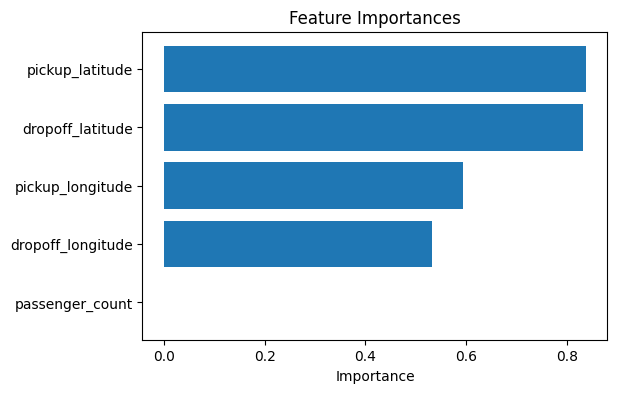

In [12]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

results = permutation_importance(first_model, val_X, val_y, random_state=0)

# Extracting the importances
importances = results.importances_mean

# Sorting the importances in descending order
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [val_X.columns[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
display()


Before seeing these results, we might have expected each of the 4 directional features to be equally important. But, on average, the latitude features matter more than the longititude features

1. Travel might tend to have greater latitude distances than longitude distances. If the longitudes values were generally closer together, shuffling them wouldn't matter as much. 

2. Different parts of the city might have different pricing rules (e.g. price per mile), and pricing rules could vary more by latitude than longitude. 

3. Tolls might be greater on roads going North<->South (changing latitude) than on roads going East <-> West (changing longitude). Thus latitude would have a larger effect on the prediction because it captures the amount of the tolls.

Without detailed knowledge of New York City, it's difficult to rule out most hypotheses about why latitude features matter more than longitude.

A good next step is to disentangle the effect of being in certain parts of the city from the effect of total distance traveled.

In [13]:
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

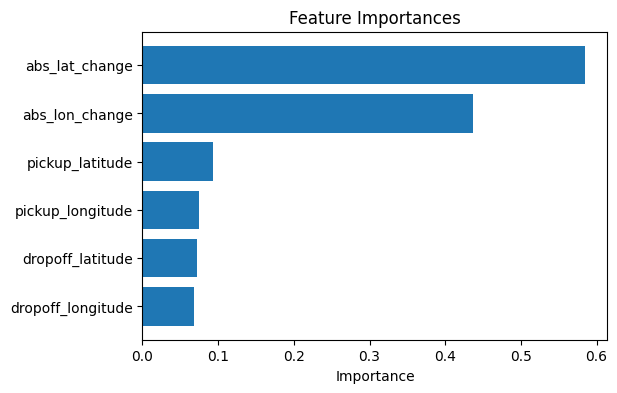

In [15]:
results = permutation_importance(second_model, new_val_X, new_val_y, random_state=0)

# Extracting the importances
importances = results.importances_mean

# Sorting the importances in descending order
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [new_val_X.columns[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
display()

### Question 1

A colleague observes that the values for abs_lon_change and abs_lat_change are pretty small (all values are between -0.1 and 0.1), whereas other variables have larger values. Do you think this could explain why those coordinates had larger permutation importance values in this case?

Consider an alternative where you created and used a feature that was 100X as large for these features, and used that larger feature for training and importance calculations. Would this change the outputted permutaiton importance values?

The scale of features does not affect permutation importance per se. The only reason that rescaling a feature would affect PI is indirectly, if rescaling helped or hurt the ability of the particular learning method we're using to make use of that feature. That won't happen with tree based models, like the Random Forest used here. If you are familiar with Ridge Regression, you might be able to think of how that would be affected. That said, the absolute change features are have high importance because they capture total distance traveled, which is the primary determinant of taxi fares...It is not an artifact of the feature magnitude.

### Question 2
You've seen that the feature importance for latitudinal distance is greater than the importance of longitudinal distance. From this, can we conclude whether travelling a fixed latitudinal distance tends to be more expensive than traveling the same longitudinal distance?

We cannot tell from the permutation importance results whether traveling a fixed latitudinal distance is more or less expensive than traveling the same longitudinal distance. Possible reasons latitude feature are more important than longitude features 

1. latitudinal distances in the dataset tend to be larger 
2. it is more expensive to travel a fixed latitudinal distance 
3. Both of the above If abs_lon_change values were very small, longitues could be less important to the model even if the cost per mile of travel in that direction were high.